# Predict TripAdvisor Rating

# import

In [636]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import datetime

# Import the modul for splitting a dataset:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [637]:
# fixing RANDOM_SEED to get an experiment reproducible

RANDOM_SEED = 42

In [638]:
# fixing packet version:

!pip freeze > requirements.txt

In [639]:
# Libraries
from sklearn.model_selection import train_test_split
import re
from scipy.stats import ttest_ind
from itertools import combinations
import collections
from datetime import datetime, date, time
sns.set()


# Show more rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# DATA

In [640]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [641]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [642]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [643]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [644]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [645]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [646]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [647]:
# uniting the train and test dataframe for the correct processing of the parameters 

df_train['sample'] = 1 # this is train set
df_test['sample'] = 0 # this is train set
df_test['Rating'] = 0 # there are no Rating in the test, we fill it with 0

df = df_test.append(df_train, sort=False).reset_index(drop=True) # merger test with train

In [648]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


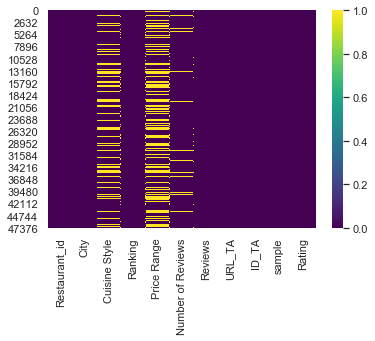

In [649]:
# Missing values visualisations:
sns.heatmap(df.isnull(), cmap='viridis')

Details of the parameters:
* City: city of the restaurant 
* Cuisine Style: suisine styles presented in the restaurant
* Ranking: the range of restaurant regarding other restaurantsin the city
* Price Range: price category
* Number of Reviews: number of comments about the restaurant
* Reviews: two the latest reviews and their dates
* URL_TA: the url-adress of the restaurant on the 'www.tripadvisor.com' 
* ID_TA: ID of the restaurant on TripAdvisor
* Rating: rating of the restaurant

Let's define some functions:

In [650]:
# first check of the columns:
def first_acquaintance(column, df=df, times=10, times_plot = 10):
    print(
        f'There are {df[column].isnull().sum()} missing values in the column "{column}":')
    print(
        f'\nThere are {df[column].nunique()} unique values:')
    sns.countplot(x=column, data=df[df[column].isin(df[column].value_counts()[:times_plot].index.tolist())])
    print(df[column].value_counts())
    print(f'\nValues that appear in the column more then {times} times:', (
        df[column].value_counts() > times).sum())
    print('\nGenerate descriptive statistics:\n', df[column].describe())

In [651]:
# depicting a numerical column through its quartiles.
def quartile_analysis(column, df=df, bins_hist=10):
    median = df[column].median()
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    print(
        f'25th quantile: {perc25}\n 75th quantile: {perc75}\n IQR: {IQR}\n limits of outliers: [{perc25-1.5*IQR}, {perc75+1.5*IQR}]')
    df[column].loc[df[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(
        bins=bins_hist, range=(df[column].min()*0.9, df[column].max()*1.1), label='IQR')
    df[column].loc[~df[column].between(perc25-1.5*IQR, perc75+1.5*IQR)].hist(
        bins=bins_hist, range=(df[column].min()*0.9, df[column].max()*1.1), label='Outliers')
    plt.legend()

In [652]:
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

In [653]:
df.columns = [x.lower() for x in df.columns]
df.columns

Index(['restaurant_id', 'city', 'cuisine style', 'ranking', 'price range',
       'number of reviews', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating'],
      dtype='object')

# Cleaning and Prepearing Data

## 1. Processing missing values

## The column 'cuisine style':

There are 11590 missing values in the column "cuisine style":

There are 10731 unique values:
['Italian']                                                                                                     1332
['French']                                                                                                      1019
['Spanish']                                                                                                      860
['French', 'European']                                                                                           503
['Cafe']                                                                                                         500
                                                                                                                ... 
['Cafe', 'Greek', 'Mediterranean', 'Healthy', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']       1
['American', 'Fast Food', 'Healthy', 'Vegetarian Friendly']                            

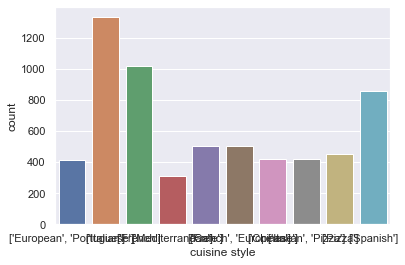

In [654]:
a_column = 'cuisine style'
first_acquaintance(a_column, df=df, times=300, times_plot = 10)

In [655]:
str_fillna = "['European']"
df['cuisine style']= df['cuisine style'].fillna(str_fillna)

## The column 'price range':

There are 17361 missing values in the column "price range":

There are 3 unique values:
$$ - $$$    23041
$            7816
$$$$         1782
Name: price range, dtype: int64

Values that appear in the column more then 100 times: 3

Generate descriptive statistics:
 count        32639
unique           3
top       $$ - $$$
freq         23041
Name: price range, dtype: object


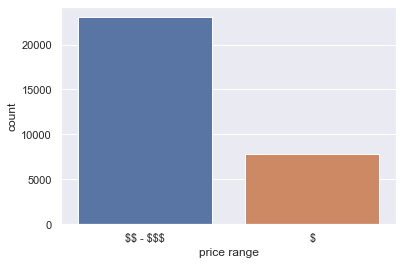

In [656]:
a_column = 'price range'
first_acquaintance(a_column, df=df, times=100, times_plot = 2)

In [657]:
df['price range'] = df['price range'].fillna('$$ - $$$') # filling the missing values with '$$ - $$$'

> ## The column 'number of reviews':

There are 3200 missing values in the column "number of reviews":

There are 1573 unique values:
2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: number of reviews, Length: 1573, dtype: int64

Values that appear in the column more then 100 times: 85

Generate descriptive statistics:
 count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: number of reviews, dtype: float64


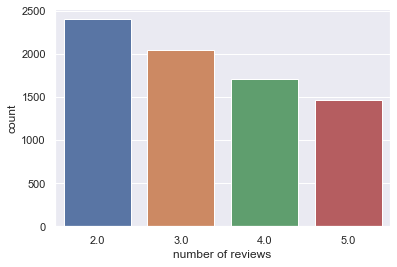

In [658]:
a_column = 'number of reviews'
first_acquaintance(a_column, df=df, times=100, times_plot = 5)

In [659]:
df['number of reviews'] = df['number of reviews'].fillna(1) # filling the missing values with 1

## The column 'reviews':

There are 2 missing values in the column "reviews":

There are 41857 unique values:
[[], []]                                                                                               8112
[['Excellent cuisine, friendly and helpful se...', 'Not tasty'], ['12/25/2016', '06/05/2016']]            2
[['Great Asian Option', 'Wow'], ['10/16/2017', '09/07/2016']]                                             2
[['Simply Excellent!', 'Modern!'], ['10/22/2017', '08/29/2017']]                                          2
[['Sat night', 'Can\'t even explain.. "A" place.. A "100...'], ['10/22/2017', '05/11/2017']]              2
                                                                                                       ... 
[['Friendly bar, great coffee and aperativos'], ['05/09/2015']]                                           1
[['Quite authentic taste of malaysia - be pre...', 'Worth the queu'], ['12/30/2017', '12/22/2017']]       1
[['Nice place for a coffee and something to e...'], 

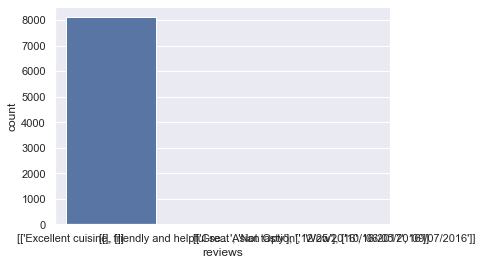

In [660]:
a_column = 'reviews'
first_acquaintance(a_column, df=df, times=100, times_plot = 3)

In [661]:
df['reviews'] = df['reviews'].fillna('[[], []]') # filling the missing values with '[[], []]'

## 2. Processing the parameters and creating new parameters

Let's consider the columns:

In [662]:
df.nunique(dropna=False) # number of unique values in  columns

restaurant_id        13094
city                    31
cuisine style        10731
ranking              12975
price range              3
number of reviews     1574
reviews              41857
url_ta               49963
id_ta                49963
sample                   2
rating                  10
dtype: int64

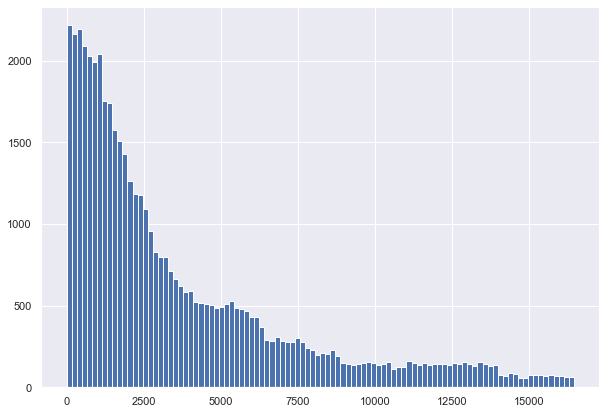

In [663]:
# visualisation of ranking parameter
plt.rcParams['figure.figsize'] = (10,7)
df['ranking'].hist(bins=100)

We see that the ranking distribution is unevenly.   
Let's see on the amount of cities:

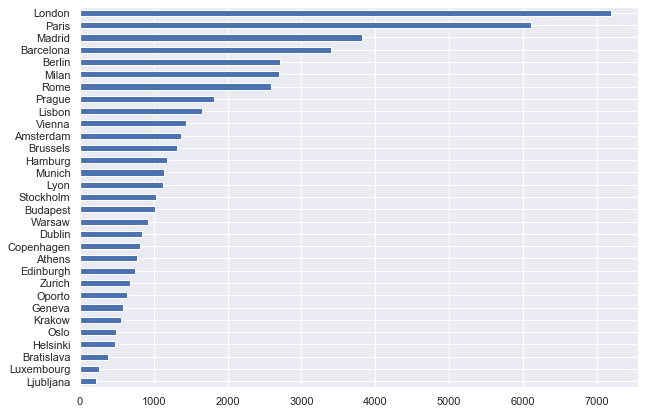

In [664]:
df['city'].value_counts(ascending=True).plot(kind='barh')

So it's could be usable to consider the parameter separately by city.   
Let's check the hypotese:

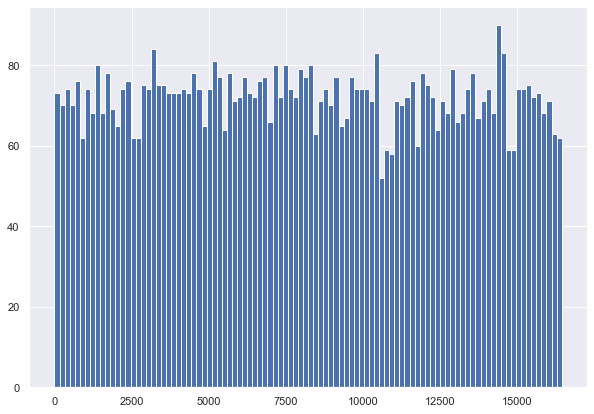

In [665]:
df['ranking'][df['city'] =='London'].hist(bins=100)

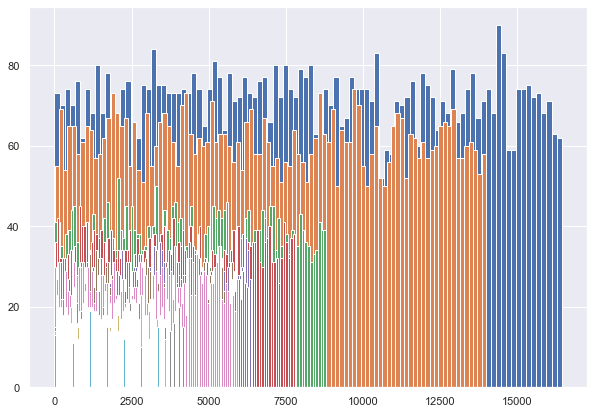

In [666]:
# Let's see the Top-10 city

for x in (df['city'].value_counts())[0:10].index:
    df['ranking'][df['city'] == x].hist(bins=100)
plt.show()

We see, the ranking parameters have an even distribution inside the cities.  
Probably we have to proceed the parameters taking into account the city.
What is with other parameters?

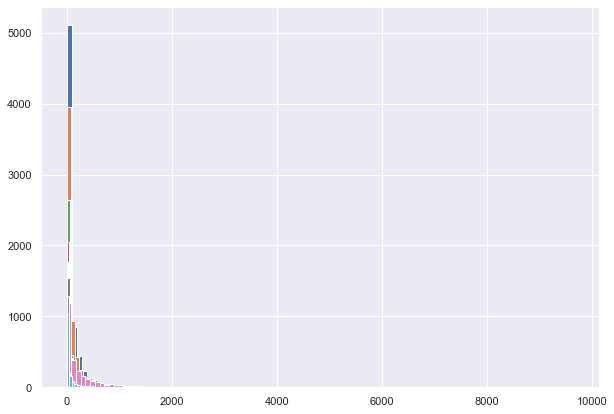

In [667]:
# Let's see the 'number fo reviews' for the Top-10 city
for x in (df['city'].value_counts())[0:10].index:
    df['number of reviews'][df['city'] == x].hist(bins=100)
plt.show()

It seems, there are some outliers inside some cities for processing.

In [668]:
df.groupby(['city'])['number of reviews'].agg(
    ['mean', 'max', 'min', 'median']).sort_values(by = 'mean',ascending = False)

,mean,max,min,median
city,,,,
Rome,281.309772,8927.0,1.0,112.0
Edinburgh,231.038926,4567.0,1.0,66.0
Milan,160.163697,6360.0,1.0,42.0
Dublin,146.942584,3491.0,1.0,37.0
Budapest,145.398629,7575.0,1.0,19.0
Amsterdam,141.314140,6777.0,1.0,40.0
London,129.875573,9660.0,1.0,32.0
Barcelona,126.558763,4996.0,1.0,29.0
Oporto,125.230530,3206.0,1.0,31.0


London
25th quantile: 7.0
 75th quantile: 121.0
 IQR: 114.0
 limits of outliers: [-164.0, 292.0]
Paris
25th quantile: 9.0
 75th quantile: 123.0
 IQR: 114.0
 limits of outliers: [-162.0, 294.0]
Madrid
25th quantile: 7.0
 75th quantile: 82.0
 IQR: 75.0
 limits of outliers: [-105.5, 194.5]
Barcelona
25th quantile: 7.0
 75th quantile: 117.5
 IQR: 110.5
 limits of outliers: [-158.75, 283.25]
Berlin
25th quantile: 4.0
 75th quantile: 45.0
 IQR: 41.0
 limits of outliers: [-57.5, 106.5]
Milan
25th quantile: 9.0
 75th quantile: 189.75
 IQR: 180.75
 limits of outliers: [-262.125, 460.875]
Rome
25th quantile: 31.0
 75th quantile: 338.0
 IQR: 307.0
 limits of outliers: [-429.5, 798.5]
Prague
25th quantile: 4.0
 75th quantile: 64.0
 IQR: 60.0
 limits of outliers: [-86.0, 154.0]
Lisbon
25th quantile: 6.0
 75th quantile: 101.0
 IQR: 95.0
 limits of outliers: [-136.5, 243.5]
Vienna
25th quantile: 5.0
 75th quantile: 61.0
 IQR: 56.0
 limits of outliers: [-79.0, 145.0]
Amsterdam
25th quantile: 10.0
 75t

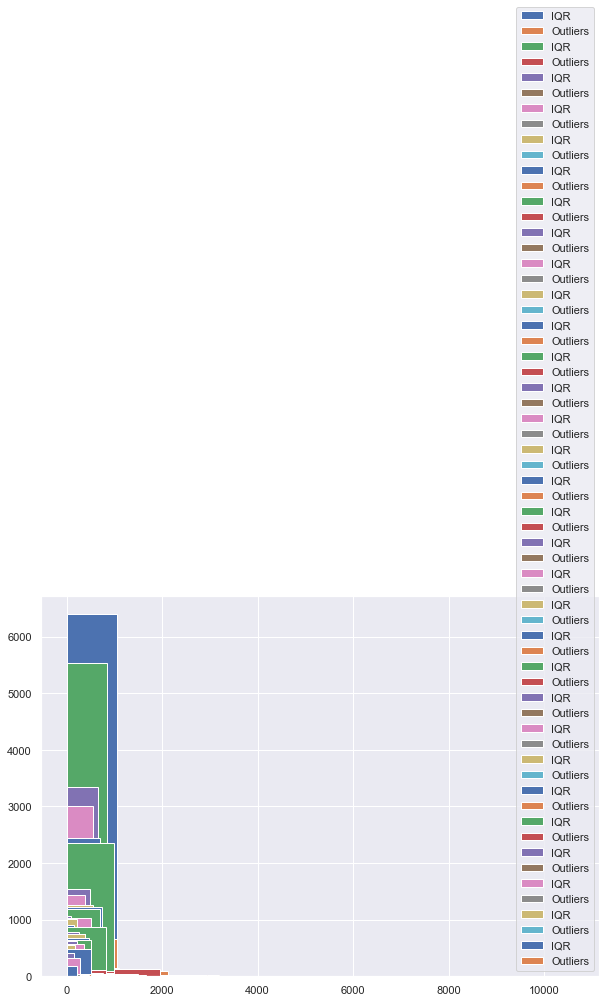

In [669]:
for x in (df['city'].value_counts()).index:
    print(x)
    quartile_analysis('number of reviews', df=df[df['city']==x], bins_hist=10)

 It's known, that the Random Forest model is robust to outliers.  
 I treid to handle outliers, but MAE become worse, the quality of the prediction reduced.   
 Therefor I will not process the outliers.

Let's explore the parameters and create a new ones, if it' possible.

## Column 'restaurant_id'

There are 0 missing values in the column "restaurant_id":

There are 13094 unique values:
id_871      19
id_227      19
id_633      19
id_436      19
id_585      18
            ..
id_9848      1
id_13525     1
id_7915      1
id_12108     1
id_10944     1
Name: restaurant_id, Length: 13094, dtype: int64

Values that appear in the column more then 15 times: 65

Generate descriptive statistics:
 count      50000
unique     13094
top       id_871
freq          19
Name: restaurant_id, dtype: object


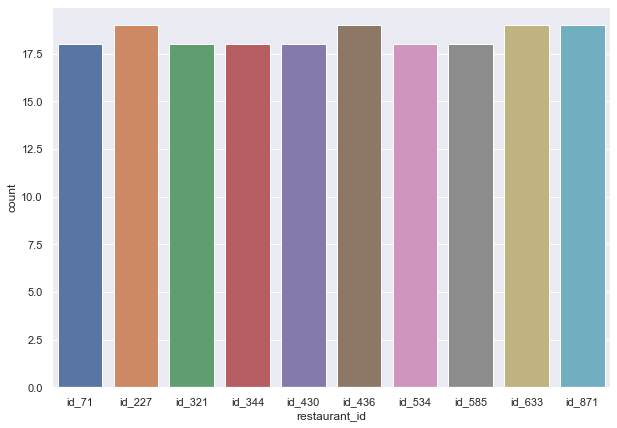

In [670]:
a_column = 'restaurant_id'
first_acquaintance(a_column, times=15, times_plot=10)

We can see, some values appear more than one time.    
We can create a new parameter: 'chain', that show how many restaurantes withe the same id there are in the Dataset.

In [671]:
df['chain'] = 0
df_chain = df[a_column].value_counts()
df['chain'] = df['restaurant_id'].apply(lambda x: df_chain.loc[x])

## Column 'city'

There are 0 missing values in the column "city":

There are 31 unique values:
London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: city, dtype: int64

Values that appear in the column more then 2000 times: 7

Generate descriptive statistics:
 count      50000
unique        31
top       London
freq        7193
Name: city, dtype: object


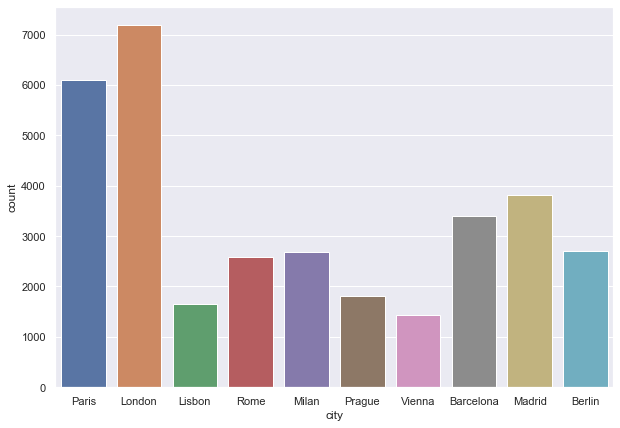

In [672]:
a_column = 'city'
first_acquaintance(a_column, df=df, times=2000, times_plot=10)

The column 'city' is categorical. We use the "One-Hot encoding" to handle the parameter:

In [673]:
dummy = pd.get_dummies(df['city'])
df = pd.concat([df, dummy], axis=1)

In [674]:
df.sample(5)

,restaurant_id,city,cuisine style,ranking,price range,number of reviews,reviews,url_ta,id_ta,sample,rating,chain,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
40664,id_3367,Prague,"['Czech', 'Central European', 'European']",3374.0,$$ - $$$,20.0,[['Pictures are definitely not those of this.....,/Restaurant_Review-g274707-d1232683-Reviews-Re...,d1232683,1,3.5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9880,id_9880,Krakow,['European'],984.0,$$ - $$$,1.0,"[[], []]",/Restaurant_Review-g274772-d13144634-Reviews-G...,d13144634,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11670,id_194,Geneva,"['European', 'French', 'Mediterranean', 'Veget...",195.0,$$ - $$$,143.0,"[['Still my favourite resto in town', 'Artisti...",/Restaurant_Review-g188057-d697925-Reviews-Caf...,d697925,1,4.0,12,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44287,id_598,Berlin,"['Asian', 'Tibetan', 'Nepali', 'Vegetarian Fri...",599.0,$,98.0,"[['Amazing curry', 'Exciting dishes from far a...",/Restaurant_Review-g187323-d1204238-Reviews-Ti...,d1204238,1,4.0,10,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25610,id_5386,Barcelona,['Spanish'],5387.0,$$ - $$$,4.0,"[['Typical Catalan Menu Restaurant'], ['10/26/...",/Restaurant_Review-g187497-d4173638-Reviews-El...,d4173638,1,4.5,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We can also culculate the number of restaurants in each city and add an appropriate parameter to the Dataset: 'amount_in_city'.

In [675]:
df['amount_in_city'] = 0
df_amount_in_city = df[a_column].value_counts() # auxiliary DataFrame with the number of restaurants in each city  
df['amount_in_city'] = df['city'].apply(lambda x: df_amount_in_city.loc[x])

In [676]:
df[['city', 'amount_in_city']].sample(15)

,city,amount_in_city
43784,Athens,776
18087,Oporto,642
18765,Stockholm,1033
39279,Vienna,1443
30430,Barcelona,3395
20520,Berlin,2705
19391,Stockholm,1033
28737,London,7193
13874,Paris,6108
6992,Luxembourg,263


## Column 'cuisine style'

There are 0 missing values in the column "cuisine style":

There are 10731 unique values:
['European']                                                                                                    11835
['Italian']                                                                                                      1332
['French']                                                                                                       1019
['Spanish']                                                                                                       860
['French', 'European']                                                                                            503
                                                                                                                ...  
['Cafe', 'Greek', 'Mediterranean', 'Healthy', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']        1
['American', 'Fast Food', 'Healthy', 'Vegetarian Friendly']                         

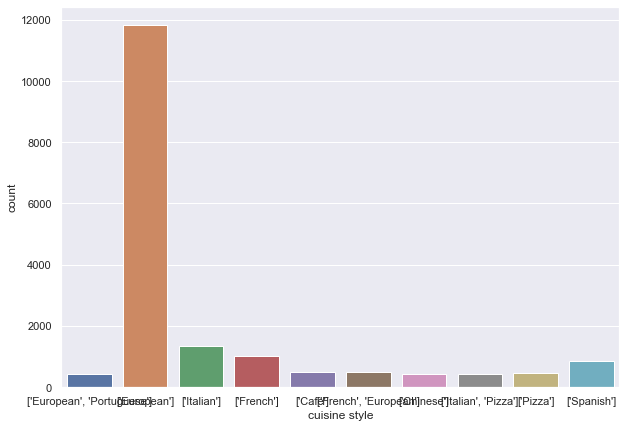

In [677]:
a_column = 'cuisine style'
first_acquaintance(a_column, df=df, times=2000, times_plot=10)

We have to handle values and creating a new parameters to use in the model.

In [678]:
pattern = re.compile("'[A-Za-z ]*'")


# function to separate the cuisine styles
def func_list(a):
    a = [x[1:-1] for x in pattern.findall(str(a))]
    return a


# transform value in the column in the list
df['cuisine style']= df['cuisine style'].apply(func_list)

In [679]:
# new parameter 'cuisine_amount': number of cuisine in the restaurant
df['cuisine_amount'] = df['cuisine style'].apply(lambda x: len(x) if len(x)>0 else 1)

In [680]:
df[['cuisine_amount', 'cuisine style']]

,cuisine_amount,cuisine style
0,2,"[Bar, Pub]"
1,5,"[European, Scandinavian, Gluten Free Options, ..."
2,1,[Vegetarian Friendly]
3,5,"[Italian, Mediterranean, European, Vegetarian ..."
4,6,"[Italian, Mediterranean, European, Seafood, Ve..."
...,...,...
49995,4,"[Italian, Vegetarian Friendly, Vegan Options, ..."
49996,5,"[French, American, Bar, European, Vegetarian F..."
49997,2,"[Japanese, Sushi]"
49998,5,"[Polish, European, Eastern European, Central E..."


The column 'cuisine style' is categorical. We use the "One-Hot encoding" to handle the parameter:

In [681]:
df_cuisine_dummy = df['cuisine style'].str.join(',')
df_cuisine_dummy = pd.get_dummies(df_cuisine_dummy.str.split(',', expand=True).stack())
df_cuisine_dummy_turned = df_cuisine_dummy.groupby(level=0).sum()
df_cuisine_dummy_turned

,,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,Belgian,Brazilian,Brew Pub,British,Burmese,Cafe,Cambodian,Canadian,Caribbean,Caucasian,Central American,Central Asian,Central European,Chilean,Chinese,Colombian,Contemporary,Croatian,Cuban,Czech,Danish,Delicatessen,Diner,Dutch,Eastern European,Ecuadorean,Egyptian,Ethiopian,European,Fast Food,Filipino,French,Fujian,Fusion,Gastropub,Georgian,German,Gluten Free Options,Greek,Grill,Halal,Hawaiian,Healthy,Hungarian,Indian,Indonesian,International,Irish,Israeli,Italian,Jamaican,Japanese,Korean,Kosher,Latin,Latvian,Lebanese,Malaysian,Mediterranean,Mexican,Middle Eastern,Minority Chinese,Mongolian,Moroccan,Native American,Nepali,New Zealand,Norwegian,Pakistani,Persian,Peruvian,Pizza,Polish,Polynesian,Portuguese,Pub,Romanian,Russian,Salvadoran,Scandinavian,Scottish,Seafood,Singaporean,Slovenian,Soups,South American,Southwestern,Spanish,Sri Lankan,Steakhouse,Street Food,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
49996,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [682]:
df = pd.concat([df, df_cuisine_dummy_turned], axis=1).drop("", axis=1)


## Column 'price range'

There are 0 missing values in the column "price range":

There are 3 unique values:
$$ - $$$    40402
$            7816
$$$$         1782
Name: price range, dtype: int64

Values that appear in the column more then 100 times: 3

Generate descriptive statistics:
 count        50000
unique           3
top       $$ - $$$
freq         40402
Name: price range, dtype: object


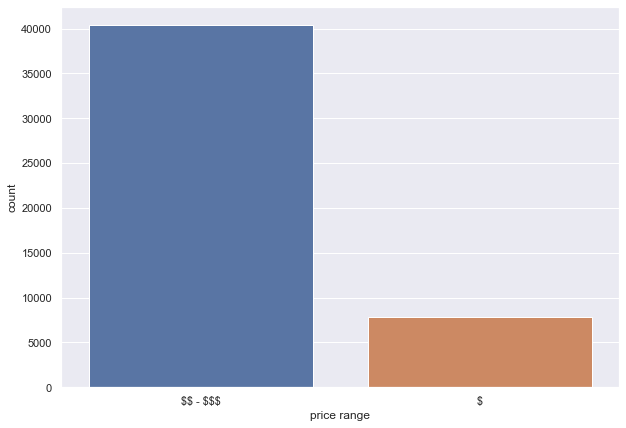

In [683]:
a_column = 'price range'
first_acquaintance(a_column, df=df, times=100, times_plot = 2)

The column 'price range'' is categorical. We use the "Label Encoding" to handle the parameter:

In [684]:
def func_price(row):
    dict_price = {'$':0, '$$ - $$$':1, '$$$$':2}
    row['price range_cat'] = dict_price[row['price range']]
    return row
    
    
df['price range_cat'] = 0
df = df.apply(func_price, axis=1)

## Column 'reviews'

In [685]:
df['reviews']

0                                                 [[], []]
1        [['Very good reviews!', 'Fine dining in Hakani...
2        [['Better than the Links', 'Ivy Black'], ['12/...
3        [['Most exquisite', 'Delicious and authentic']...
4        [['Always the best in bratislava', 'Very good ...
                               ...                        
49995    [['The real Italian experience!', 'Wonderful f...
49996    [['Parisian atmosphere', 'Bit pricey but inter...
49997    [['Good by swedish standards', 'A hidden jewel...
49998    [['Underground restaurant', 'Oldest Restaurant...
49999    [['Average', 'Nice an informal'], ['01/31/2016...
Name: reviews, Length: 50000, dtype: object

Let's pull the the dates of reviews out and create a new column 'reviews_dates'

In [686]:
pattern_date = re.compile("\d\d\/\d\d\/\d\d\d\d")

def func_date(t):
    t = [x for x in pattern_date.findall(str(t))]
    t = pd.to_datetime(t).sort_values()
    
    return t


df['reviews_dates']= df['reviews'].apply(func_date)

In [687]:
df['reviews_dates']

0        DatetimeIndex([], dtype='datetime64[ns]', freq...
1        DatetimeIndex(['2017-10-29', '2017-12-05'], dt...
2        DatetimeIndex(['2017-12-06', '2017-12-28'], dt...
3        DatetimeIndex(['2017-11-22', '2017-12-06'], dt...
4        DatetimeIndex(['2018-01-24', '2018-02-08'], dt...
                               ...                        
49995    DatetimeIndex(['2017-11-12', '2017-12-16'], dt...
49996    DatetimeIndex(['2017-12-12', '2017-12-21'], dt...
49997    DatetimeIndex(['2008-04-12', '2016-11-03'], dt...
49998    DatetimeIndex(['2017-06-18', '2017-07-11'], dt...
49999    DatetimeIndex(['2012-07-04', '2016-01-31'], dt...
Name: reviews_dates, Length: 50000, dtype: object

In [688]:
# new parameter 'reviews_amount': number of  reviews published  on the 'www.tripadvisor.com' 
df["reviews_amount"] = df['reviews_dates'].apply(lambda x: len(x))

In [689]:
df[['reviews_dates', "reviews_amount"]].sample(20)

,reviews_dates,reviews_amount
32570,"DatetimeIndex(['2017-10-23', '2017-12-28'], dt...",2
33252,"DatetimeIndex(['2017-12-17'], dtype='datetime6...",1
15279,"DatetimeIndex(['2016-10-08', '2016-12-21'], dt...",2
38325,"DatetimeIndex(['2017-04-04', '2017-05-14'], dt...",2
39838,"DatetimeIndex(['2017-01-25', '2017-08-03'], dt...",2
4327,"DatetimeIndex(['2017-09-24', '2017-10-02'], dt...",2
929,"DatetimeIndex(['2014-03-03'], dtype='datetime6...",1
39951,"DatetimeIndex(['2017-04-26', '2017-04-26'], dt...",2
5710,"DatetimeIndex(['2017-07-19', '2017-12-31'], dt...",2
7802,"DatetimeIndex(['2017-12-28'], dtype='datetime6...",1


In [690]:
# function to create 4 new parameters: dates of 2 reviews, difference between reviews (timestamp-format) and frequency of reviews 
def func_date_publ(row):
    if row['reviews_amount'] == 2:
        row['reviews_date_earlier'] = row['reviews_dates'][0]
        row['reviews_date_later'] = row['reviews_dates'][1]
        row['reviews_diff'] = datetime.timestamp(row['reviews_date_later']) - datetime.timestamp(row['reviews_date_earlier'])
        row['reviews_freq'] = row['reviews_diff'] / row['number of reviews']
        
    return row


df['reviews_date_earlier'] = 0
df['reviews_date_later'] = 0
df['reviews_diff'] = 0
df['reviews_freq'] = 0

df = df.apply(func_date_publ, axis=1)

In [691]:
# function to create 2 new parameters: difference between reviews (in days) and frequency of reviews 
def delta_time(row):
    if row['reviews_amount'] == 2:
        d_later = row['reviews_date_later']
        d_earlier = row['reviews_date_earlier']
        d_time = d_later - d_earlier
        row['delta_time'] = d_time.days
        row['reviews_freq_1'] = row['delta_time'] / row['number of reviews']
    return row

df['reviews_freq_1'] = 0
df['delta_time'] = 0
df = df.apply(delta_time, axis=1)

Now we will handle reviews:

In [692]:
# let's see wich words were used by visitors:
cnt1 = collections.Counter()
pattern = re.compile('[a-z]*')
for word in df.reviews.str.lower():
    word_list = pattern.findall(word)
    cnt1 += collections.Counter(word_list)
cnt1.most_common(20)

[('', 1991022),
 ('food', 13166),
 ('good', 11780),
 ('great', 10628),
 ('and', 9765),
 ('a', 8331),
 ('in', 6216),
 ('the', 6187),
 ('nice', 5702),
 ('place', 5166),
 ('for', 4803),
 ('service', 4383),
 ('very', 4208),
 ('restaurant', 3632),
 ('best', 3411),
 ('excellent', 3261),
 ('to', 2927),
 ('of', 2710),
 ('lunch', 2694),
 ('but', 2559)]

After analisys of the vocabulary we make 3 lists for a subsequent processing:

In [693]:
list_superlative = ['great', 'best', 'excellent', 'lovely', 'amazing', 'fantastic', 'perfect', 'wonderful', 
                    'super', 'cool', 'fine', 'favourite', 'brilliant', 'favorite', 'outstanding', 'happy', 
                    'delightful', 'incredible', 'gorgeous', 'gourmet', 'excelent', 'ideal', 'perfectly', 
                    'paradise', 'impressive', 'supper'] 

list_positive = ['good', 'nice', 'delicious', 'friendly', 'tasty', 'cosy', 'cozy', 'awesome', 'beautiful', 
                 'healthy', 'affordable',  'welcoming', 'recommend', 'relaxing', 'homemade', 'delight', 
                 'stylish', 'romantic', 'creative',  'hospitality', 'elegant',  'impressed', 'tasteful'] 

list_negative = ['bad', 'worst', 'terrible', 'disappointing', 'slow', 'overpriced', 'awful', 'disappointed', 
                 'unfriendly', 'disappointment', 'shame', 'dirty', 'tasteless', 'overrated']

df['positive'] = 0
df['superlative'] = 0
df['negative'] = 0

In [694]:
# function to count a number of superlative, positive and negative words in reviews: 

def func_review(row):
    global list_positive
    global list_negative
    global list_superlative
    pattern = re.compile('[a-z]*')
    word_list = pattern.findall(row['reviews'].lower())
    for word in word_list:
        if word in list_positive:
            row['positive'] += 1
        if word in list_negative:
            row['negative'] += 1
        if word in list_superlative:
            row['superlative'] += 1
    return row


df = df.apply(func_review, axis=1)

# Further processing

As we saw, the ranking parameters have an even distribution inside the cities.  
We can use this observation to create new parameters, not only from "ranking".

In [695]:
# creation new parameter: 'weight_in_city'
df['weight_in_city'] = df['amount_in_city'] / df['ranking']

In [696]:
# creation new parameter: 'rev'
df['rev'] = df['reviews_amount'] * df['weight_in_city']

In [697]:
# creation new parameter: 'reviews_city'
df_gr_city_reviews = df.groupby(['city'])['number of reviews'].sum() # auxiliary DataFrame
df['reviews_city'] = df.apply(lambda x: df_gr_city_reviews.loc[x.city], axis=1)

In [698]:
# creation new parameter: 'reviews_city_def'
df['reviews_city_def'] = df['number of reviews'] / df['reviews_city']

In [699]:
# creation new parameter: 'reviews_ranking'
df['reviews_ranking'] = df['number of reviews'] * df['weight_in_city']

In [700]:
# Min-max rationing of 'ranking' inside city. New parameter: 'ranking_norm'.
df['ranking_norm'] = 0
df_ranking_min_max = df.groupby(['city'])['ranking'].agg(['min', 'max'])
df_ranking_min_max['max-min'] = df_ranking_min_max['max'] - df_ranking_min_max['min']


def func_ranking_norm(row):
    min_max_row = df_ranking_min_max.loc[row.city]
    row['ranking_norm'] = (row['ranking'] - min_max_row['min']) / min_max_row['max-min']
    return row


df = df.apply(func_ranking_norm, axis=1)

In [701]:
df[['ranking', 'ranking_norm']]

,ranking,ranking_norm
0,12963.0,0.926840
1,106.0,0.089710
2,810.0,0.458357
3,1669.0,0.101441
4,37.0,0.038375
...,...,...
49995,500.0,0.079535
49996,6341.0,0.453265
49997,1652.0,0.670321
49998,641.0,0.297260


In [702]:
# Min-max rationing of 'number of reviews' inside city. New parameter: 'number of reviews_norm'.
df['number of reviews_norm'] = 0
df_reviews_min_max = df.groupby(['city'])['number of reviews'].agg(['min', 'max'])
df_reviews_min_max['max-min'] = df_reviews_min_max['max'] - df_reviews_min_max['min']


def func_reviews_norm(row):
    min_max_row = df_reviews_min_max.loc[row.city]
    row['number of reviews_norm'] = (row['number of reviews'] - min_max_row['min']) / min_max_row['max-min']
    return row


df = df.apply(func_reviews_norm, axis=1)

In [703]:
df[['number of reviews', 'number of reviews_norm']]

,number of reviews,number of reviews_norm
0,4.0,0.000394
1,97.0,0.064560
2,28.0,0.005913
3,202.0,0.020810
4,162.0,0.062476
...,...,...
49995,79.0,0.012266
49996,542.0,0.070988
49997,4.0,0.002055
49998,70.0,0.029299


In [704]:
# Min-max rationing of 'weight_in_city' inside city. New parameter: 'weight_norm'.
df['weight_norm'] = 0
df_weight_min_max = df.groupby(['city'])['weight_in_city'].agg(['min', 'max'])
df_weight_min_max['max-min'] = df_weight_min_max['max'] - df_weight_min_max['min']



def func_weight_norm(row):
    min_max_row = df_weight_min_max.loc[row.city]
    row['weight_norm'] = (row['weight_in_city'] - min_max_row['min']) / min_max_row['max-min']
    return row


df = df.apply(func_weight_norm, axis=1)
df[['weight_in_city', 'weight_norm']]

,weight_in_city,weight_norm
0,0.471187,0.000017
1,4.481132,0.034351
2,0.919753,0.000669
3,4.309766,0.000538
4,10.270270,0.077970
...,...,...
49995,5.388000,0.001841
49996,0.963255,0.000259
49997,0.625303,0.000200
49998,1.443058,0.001096


I suppose, we created enough parameters for the model.   
But before we will see the result, let's review the correlation matrix of the result dataset:

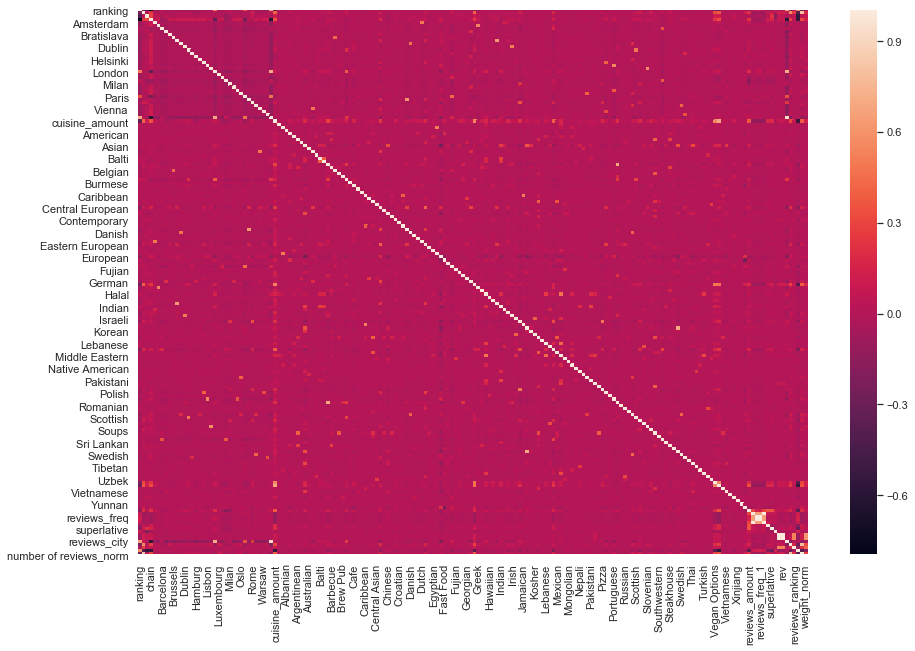

In [705]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df[df['sample']==1].drop(['sample'], axis=1).corr())

Because of too many columns in the dataset it's not possible to make analysis with a heatmap.
let's check the numbers.

In [706]:
df_corr = df[df['sample']==1].drop(['sample'], axis=1).corr()
df_corr

,ranking,number of reviews,rating,chain,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,amount_in_city,cuisine_amount,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,Belgian,Brazilian,Brew Pub,British,Burmese,Cafe,Cambodian,Canadian,Caribbean,Caucasian,Central American,Central Asian,Central European,Chilean,Chinese,Colombian,Contemporary,Croatian,Cuban,Czech,Danish,Delicatessen,Diner,Dutch,Eastern European,Ecuadorean,Egyptian,Ethiopian,European,Fast Food,Filipino,French,Fujian,Fusion,Gastropub,Georgian,German,Gluten Free Options,Greek,Grill,Halal,Hawaiian,Healthy,Hungarian,Indian,Indonesian,International,Irish,Israeli,Italian,Jamaican,Japanese,Korean,Kosher,Latin,Latvian,Lebanese,Malaysian,Mediterranean,Mexican,Middle Eastern,Minority Chinese,Mongolian,Moroccan,Native American,Nepali,New Zealand,Norwegian,Pakistani,Persian,Peruvian,Pizza,Polish,Polynesian,Portuguese,Pub,Romanian,Russian,Salvadoran,Scandinavian,Scottish,Seafood,Singaporean,Slovenian,Soups,South American,Southwestern,Spanish,Sri Lankan,Steakhouse,Street Food,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,price range_cat,reviews_amount,reviews_diff,reviews_freq,reviews_freq_1,delta_time,positive,superlative,negative,weight_in_city,rev,reviews_city,reviews_city_def,reviews_ranking,ranking_norm,number of reviews_norm,weight_norm
ranking,1.000000,-0.222012,-0.368371,-0.792996,-0.094372,-0.095177,0.017390,-0.026367,-0.075669,-0.095232,-0.095534,-0.094270,-0.094965,-0.092951,-0.088282,-0.097555,-0.081664,-0.087357,-0.088900,-0.062811,0.499991,-0.065863,-0.096448,0.055754,-0.036981,-0.093938,-0.090281,-0.082608,0.328009,-0.083389,-0.043718,-0.094931,-0.092039,-0.095860,-0.091098,0.709143,-0.320319,0.003787,0.002444,-0.009108,-0.007148,-0.008968,-0.023183,0.005009,-0.006079,0.002846,-0.059935,-0.004919,0.020966,0.035727,-0.038656,-0.039053,-0.049691,-0.011678,-0.018321,0.088980,0.005123,0.004020,0.004709,-0.001825,0.027111,-0.006133,-0.018318,0.000875,-0.138591,0.002969,0.048163,0.001419,-0.038237,-0.014603,0.004656,-0.057845,-0.051471,-0.007264,-0.011183,-0.055808,-0.062108,0.008017,-0.008084,-0.006911,-0.117416,0.020242,-0.007166,0.041399,-0.003196,-0.036274,-0.018718,-0.009723,-0.063254,-0.214648,-0.068879,-0.009417,0.042595,-0.008818,-0.021510,-0.065389,0.053583,-0.016335,-0.068846,-0.057673,-0.015631,-0.087515,0.017451,0.004166,-0.004319,0.004984,-0.031549,-0.003433,0.019364,0.021976,-0.146513,-0.001241,0.000952,-0.002750,-0.003986,0.008252,0.000566,-0.015936,0.000988,-0.036348,0.013816,0.005721,-0.008267,-0.040522,-0.069948,-0.005543,-0.087311,-0.011071,0.001863,-0.000062,-0.002304,-0.076340,-0.052334,-0.074082,0.002668,-0.038691,-0.051425,-0.014142,-0.006079,-0.016425,0.004711,-0.042967,-0.006589,-0.012049,-0.047554,-0.053201,0.003856,-0.002347,-0.007873,0.008074,0.015341,-0.005788,-0.002994,-0.214913,-0.300139,-0.006948,-0.007524,-0.004871,-0.038717,0.003640,-0.002888,-0.026525,-0.139815,0.065656,0.121868,0.121867,0.065661,-0.111683,-0.146976,0.104806,-0.060214,-0.060455,0.656301,-0.228768,-0.049620,0.572947,-0.260219,-0.105676
number of reviews,-0.222012,1.000000,0.026934,0.253117,0.013339,-0.010743,0.006199,-0.046973,-0.021581,-0.019410,0.014632,-0.014020,0.014045,0.046410,-0.022662,-0.040160,-0.020440,-0.001451,0.000858,-0.011256,0.018118,-0.010056,-0.018322,-0.023255,0.039943,-0.021806,0.003874,-0.009134,-0.002930,-0.004472,0.133525,-0.022545,-0.024206,-0.027829,-0.017894,0.027948,0.405551,-0.003224,-0.006830,-0.004250,0.043741,-0.005658,0.030249,-0.005957,0.027288,0.006218,0.017534,-0.001719,0.013531,0.002394,0.081468,0.053781,0.023000,0.009005,0.006988,0.079253,-0.00194

In [707]:
ser_corr = df_corr['rating'].abs().sort_values(ascending = False)
ser_corr

rating                    1.000000
ranking_norm              0.544704
ranking                   0.368371
chain                     0.296471
superlative               0.216323
negative                  0.202864
Vegetarian Friendly       0.128356
Vegan Options             0.122054
cuisine_amount            0.119987
Gluten Free Options       0.099455
weight_norm               0.084446
Madrid                    0.083462
Rome                      0.083082
delta_time                0.065990
reviews_diff              0.065989
Wine Bar                  0.062129
amount_in_city            0.060874
Milan                     0.059704
Healthy                   0.058532
weight_in_city            0.057352
Chinese                   0.056867
rev                       0.056645
Mediterranean             0.050665
Berlin                    0.046967
Delicatessen              0.045649
Athens                    0.044792
Greek                     0.044228
reviews_ranking           0.041355
Fusion              

It's very interesting to notice, that the follow parameters have the highest correlation with Rating: 

In [708]:
print(ser_corr[1:20])

ranking_norm           0.544704
ranking                0.368371
chain                  0.296471
superlative            0.216323
negative               0.202864
Vegetarian Friendly    0.128356
Vegan Options          0.122054
cuisine_amount         0.119987
Gluten Free Options    0.099455
weight_norm            0.084446
Madrid                 0.083462
Rome                   0.083082
delta_time             0.065990
reviews_diff           0.065989
Wine Bar               0.062129
amount_in_city         0.060874
Milan                  0.059704
Healthy                0.058532
weight_in_city         0.057352
Name: rating, dtype: float64


We will use the correlation of the parameter with rationg *ser_corr* later.
Now let's build our model.

# Data Preprocessing

At first we reload the data:

In [709]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')
df_train['sample'] = 1 # this is train set
df_test['sample'] = 0 # this is train set
df_test['Rating'] = 0 # there are no Rating in the test, we fill it with 0

data = df_test.append(df_train, sort=False).reset_index(drop=True) # merger test with train

In [710]:
# function for data preprocessing
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df = df_input.copy()
    # Convert the columns names to lowercase.
    df.columns = [x.lower() for x in df.columns]

    # ################### 1. NAN ###################################################################
    df['cuisine style'] = df['cuisine style'].fillna("['European']")
    df['price range'] = df['price range'].fillna('$$ - $$$')
    df['number of reviews'] = df['number of reviews'].fillna(1)
    df['reviews'] = df['reviews'].fillna('[[], []]')

    # ################### 2. Encoding ##############################################################

    # ################### 2.1. City ################################################################
    dummy = pd.get_dummies(df['city'])
    df = pd.concat([df, dummy], axis=1)

    # ################### 3. Feature Engineering ####################################################

    # ################### 3.1. Chain of restaurants #################################################
    df['chain'] = 0
    df_chain = df['restaurant_id'].value_counts()
    df['chain'] = df['restaurant_id'].apply(lambda x: df_chain.loc[x])

    # ################### 3.2. Restaurant amount in the city ########################################
    df['amount_in_city'] = 0
    # auxiliary DataFrame with the number of restaurants in each city
    df_amount_in_city = df['city'].value_counts()
    df['amount_in_city'] = df['city'].apply(lambda x: df_amount_in_city.loc[x])

    # ################### 3.3. Handle the column 'cuisine style' ####################################

    pattern = re.compile("'[A-Za-z ]*'")  # pattern to split a cuisine style

    
    # function to separate the cuisine styles  
    def func_list(a):
        a = [x[1:-1] for x in pattern.findall(str(a))]
        return a

    
    # transform a value in the column to a list
    df['cuisine style'] = df['cuisine style'].apply(func_list)

    # creation a new column 'cuisine_amount': number of cuisine in the restaurant
    df['cuisine_amount'] = df['cuisine style'].apply(
        lambda x: len(x) if len(x) > 0 else 1)

    # One-Hot Encoding of the column 'cuisine style'
    df_cuisine_dummy = df['cuisine style'].str.join(',')
    df_cuisine_dummy = pd.get_dummies(
        df_cuisine_dummy.str.split(',', expand=True).stack())
    df_cuisine_dummy_turned = df_cuisine_dummy.groupby(level=0).sum()
    df = pd.concat([df, df_cuisine_dummy_turned], axis=1).drop("", axis=1)

    # ################### 3.4. Lable Encoding the column 'price range' ##############################

    
    # function for the lablinge price values
    def func_price(row):
        dict_price = {'$': 0, '$$ - $$$': 1, '$$$$': 2}
        row['price range_cat'] = dict_price[row['price range']]
        return row

    
    # new columns 'price range_cat' with lables
    df['price range_cat'] = 0
    df = df.apply(func_price, axis=1)

    # ################### 3.5. Handle the column 'reviews'. Dates. ##################################
    pattern_date = re.compile("\d\d\/\d\d\/\d\d\d\d")

    
    # function to extraxt the dates
    def func_date(t):
        t = [x for x in pattern_date.findall(str(t))]
        t = pd.to_datetime(t).sort_values()
        return t

    
    # extract dates of reviews in the new column
    df['reviews_dates'] = df['reviews'].apply(func_date)

    # new parameter 'reviews_amount': number of  reviews published  on the 'www.tripadvisor.com':
    df["reviews_amount"] = df['reviews_dates'].apply(lambda x: len(x))

    
    # function to create 4 new parameters: dates of 2 reviews, difference between reviews (timestamp-format) and frequency of reviews
    def func_date_publ(row):
        if row['reviews_amount'] == 2:
            row['reviews_date_earlier'] = row['reviews_dates'][0]
            row['reviews_date_later'] = row['reviews_dates'][1]
            row['reviews_diff'] = datetime.timestamp(
                row['reviews_date_later']) - datetime.timestamp(row['reviews_date_earlier'])
            row['reviews_freq'] = row['reviews_diff'] / \
                row['number of reviews']
        return row

    
    df['reviews_date_earlier'] = 0
    df['reviews_date_later'] = 0
    df['reviews_diff'] = 0
    df['reviews_freq'] = 0
    df = df.apply(func_date_publ, axis=1)

    
    # function to create 2 new parameters: difference between reviews (in days) and frequency of reviews
    def delta_time(row):
        if row['reviews_amount'] == 2:
            d_later = row['reviews_date_later']
            d_earlier = row['reviews_date_earlier']
            d_time = d_later - d_earlier
            row['delta_time'] = d_time.days
            row['reviews_freq_1'] = row['delta_time'] / \
                row['number of reviews']
        return row

    
    df['reviews_freq_1'] = 0
    df['delta_time'] = 0
    df = df.apply(delta_time, axis=1)

    # ################### 3.6. Handle the column 'reviews'. Reviews. ################################   
    list_superlative = ['great', 'best', 'excellent', 'lovely', 'amazing', 'fantastic', 'perfect', 'wonderful',
                        'super', 'cool', 'fine', 'favourite', 'brilliant', 'favorite', 'outstanding', 'happy',
                        'delightful', 'incredible', 'gorgeous', 'gourmet', 'excelent', 'ideal', 'perfectly',
                        'paradise', 'impressive', 'supper']

    list_positive = ['good', 'nice', 'delicious', 'friendly', 'tasty', 'cosy', 'cozy', 'awesome', 'beautiful',
                     'healthy', 'affordable',  'welcoming', 'recommend', 'relaxing', 'homemade', 'delight',
                     'stylish', 'romantic', 'creative',  'hospitality', 'elegant',  'impressed', 'tasteful']

    list_negative = ['bad', 'worst', 'terrible', 'disappointing', 'slow', 'overpriced', 'awful', 'disappointed',
                     'unfriendly', 'disappointment', 'shame', 'dirty', 'tasteless', 'overrated']

    df['positive'] = 0 # new columns: amount of positive words in reviews
    df['superlative'] = 0 # new columns: amount of superlative words in reviews
    df['negative'] = 0 # new columns: amount of negative words in reviews

    
    # function to count a number of superlative, positive and negative words in reviews:
    def func_review(row):
        pattern = re.compile('[a-z]*')
        word_list = pattern.findall(row['reviews'].lower())
        for word in word_list:
            if word in list_positive:
                row['positive'] += 1
            if word in list_negative:
                row['negative'] += 1
            if word in list_superlative:
                row['superlative'] += 1
        return row

    
    df = df.apply(func_review, axis=1)

    # ################### 3.7. Creation other new parameters. ################################
    
    # creation new parameter: 'weight_in_city'
    df['weight_in_city'] = df['amount_in_city'] / df['ranking']
    df['rev'] = df['reviews_amount'] * df['weight_in_city']
    df_gr_city_reviews = df.groupby(
        ['city'])['number of reviews'].sum()  # auxiliary DataFrame
    df['reviews_city'] = df.apply(
        lambda x: df_gr_city_reviews.loc[x.city], axis=1)
    df['reviews_city_def'] = df['number of reviews'] / df['reviews_city']
    df['reviews_ranking'] = df['number of reviews'] * df['weight_in_city']

    
    # Min-max rationing of 'ranking' inside city. New parameter: 'ranking_norm'.
    df['ranking_norm'] = 0
    df_ranking_min_max = df.groupby(['city'])['ranking'].agg(['min', 'max'])
    df_ranking_min_max['max-min'] = df_ranking_min_max['max'] - \
        df_ranking_min_max['min']

    
    def func_ranking_norm(row):
        min_max_row = df_ranking_min_max.loc[row.city]
        row['ranking_norm'] = (
            row['ranking'] - min_max_row['min']) / min_max_row['max-min']
        return row

    
    df = df.apply(func_ranking_norm, axis=1)

    
    # Min-max rationing of 'number of reviews' inside city. New parameter: 'number of reviews_norm'.
    df['number of reviews_norm'] = 0
    df_reviews_min_max = df.groupby(
        ['city'])['number of reviews'].agg(['min', 'max'])
    df_reviews_min_max['max-min'] = df_reviews_min_max['max'] - \
        df_reviews_min_max['min']

    
    def func_reviews_norm(row):
        min_max_row = df_reviews_min_max.loc[row.city]
        row['number of reviews_norm'] = (
            row['number of reviews'] - min_max_row['min']) / min_max_row['max-min']
        return row

    
    df = df.apply(func_reviews_norm, axis=1)

    
    # Min-max rationing of 'weight_in_city' inside city. New parameter: 'weight_norm'.
    df['weight_norm'] = 0
    df_weight_min_max = df.groupby(
        ['city'])['weight_in_city'].agg(['min', 'max'])
    df_weight_min_max['max-min'] = df_weight_min_max['max'] - \
        df_weight_min_max['min']

    def func_weight_norm(row):
        min_max_row = df_weight_min_max.loc[row.city]
        row['weight_norm'] = (row['weight_in_city'] -
                              min_max_row['min']) / min_max_row['max-min']
        return row

    df = df.apply(func_weight_norm, axis=1)

    # ################### 4. Clean ####################################################
    # droping non-usable columns 'restaurant_id','id_ta'
    df.drop(['restaurant_id', 'id_ta'], axis=1, inplace=True)

    # droping object-columns
    object_columns = [s for s in df.columns if df[s].dtypes == 'object']
    df.drop(object_columns, axis=1, inplace=True)

    return df

In [711]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,ranking,number of reviews,sample,rating,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,chain,amount_in_city,cuisine_amount,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,Belgian,Brazilian,Brew Pub,British,Burmese,Cafe,Cambodian,Canadian,Caribbean,Caucasian,Central American,Central Asian,Central European,Chilean,Chinese,Colombian,Contemporary,Croatian,Cuban,Czech,Danish,Delicatessen,Diner,Dutch,Eastern European,Ecuadorean,Egyptian,Ethiopian,European,Fast Food,Filipino,French,Fujian,Fusion,Gastropub,Georgian,German,Gluten Free Options,Greek,Grill,Halal,Hawaiian,Healthy,Hungarian,Indian,Indonesian,International,Irish,Israeli,Italian,Jamaican,Japanese,Korean,Kosher,Latin,Latvian,Lebanese,Malaysian,Mediterranean,Mexican,Middle Eastern,Minority Chinese,Mongolian,Moroccan,Native American,Nepali,New Zealand,Norwegian,Pakistani,Persian,Peruvian,Pizza,Polish,Polynesian,Portuguese,Pub,Romanian,Russian,Salvadoran,Scandinavian,Scottish,Seafood,Singaporean,Slovenian,Soups,South American,Southwestern,Spanish,Sri Lankan,Steakhouse,Street Food,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,price range_cat,reviews_amount,reviews_diff,reviews_freq,reviews_freq_1,delta_time,positive,superlative,negative,weight_in_city,rev,reviews_city,reviews_city_def,reviews_ranking,ranking_norm,number of reviews_norm,weight_norm
24383,14445.0,131.0,1,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7193,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,86400.0,6.595420e+02,0.007634,1,0,0,0,0.497958,0.995916,934195.0,0.000140,65.232468,0.878429,0.013459,0.000008
19983,866.0,115.0,1,3.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,11,1033,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,2,3891600.0,3.384000e+04,0.391304,45,2,0,0,1.192841,2.385681,71669.0,0.001605,137.176674,0.351198,0.078082,0.000749
42822,2155.0,13.0,1,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,9,1443,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.000000e+00,0.000000,0,0,0,0,0.669606,0.000000,106827.0,0.000122,8.704872,0.625617,0.002431,0.000174
18861,3781.0,4.0,1,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3395,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,46659600.0,1.166490e+07,135.000000,540,0,0,0,0.897911,1.795821,429667.0,0.000009,3.591642,0.484662,0.000601,0.000681
4305,7513.0,19.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,3813,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,13050000.0,6.868421e+05,7.947368,151,1,2,0,0.507520,1.015041,357423.0,0.000053,9.642886,0.852861,0.0029

In [712]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 179 entries, ranking to weight_norm
dtypes: float64(14), int64(165)
memory usage: 68.3 MB


In [713]:
# extract the test part
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # our target
X = train_data.drop(['rating'], axis=1)

In [714]:
test_data

,ranking,number of reviews,rating,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,chain,amount_in_city,cuisine_amount,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,Belgian,Brazilian,Brew Pub,British,Burmese,Cafe,Cambodian,Canadian,Caribbean,Caucasian,Central American,Central Asian,Central European,Chilean,Chinese,Colombian,Contemporary,Croatian,Cuban,Czech,Danish,Delicatessen,Diner,Dutch,Eastern European,Ecuadorean,Egyptian,Ethiopian,European,Fast Food,Filipino,French,Fujian,Fusion,Gastropub,Georgian,German,Gluten Free Options,Greek,Grill,Halal,Hawaiian,Healthy,Hungarian,Indian,Indonesian,International,Irish,Israeli,Italian,Jamaican,Japanese,Korean,Kosher,Latin,Latvian,Lebanese,Malaysian,Mediterranean,Mexican,Middle Eastern,Minority Chinese,Mongolian,Moroccan,Native American,Nepali,New Zealand,Norwegian,Pakistani,Persian,Peruvian,Pizza,Polish,Polynesian,Portuguese,Pub,Romanian,Russian,Salvadoran,Scandinavian,Scottish,Seafood,Singaporean,Slovenian,Soups,South American,Southwestern,Spanish,Sri Lankan,Steakhouse,Street Food,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,price range_cat,reviews_amount,reviews_diff,reviews_freq,reviews_freq_1,delta_time,positive,superlative,negative,weight_in_city,rev,reviews_city,reviews_city_def,reviews_ranking,ranking_norm,number of reviews_norm,weight_norm
0,12963.0,4.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,16,6108,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.000000,0.000000,0,0,0,0,0.471187,0.000000,681118.0,0.000006,1.884749,0.926840,0.000394,0.000017
1,106.0,97.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,475,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,2,3200400.0,32993.814433,0.381443,37,1,1,0,4.481132,8.962264,29539.0,0.003284,434.669811,0.089710,0.064560,0.034351
2,810.0,28.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,745,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,1900800.0,67885.714286,0.785714,22,0,0,0,0.919753,1.839506,172124.0,0.000163,25.753086,0.458357,0.005913,0.000669
3,1669.0,202.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,7193,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,2,1209600.0,5988.118812,0.069307,14,1,0,0,4.309766,8.619533,934195.0,0.000216,870.572798,0.101441,0.020810,0.000538
4,37.0,162.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,380,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,2,1296000.0,8000.000000,0.092593,15,1,1,0,10.270270,20.540541,16729.0,0.009684,1663.783784,0.038375,0.062476,0.077970
...,...,...,...,...,...,...,..

In [715]:
# Using the function "train_test_split" for splitting the train set for validation
# 20% for validation (test_size value)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [716]:
# check
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 178), (40000, 178), (40000, 177), (32000, 177), (8000, 177))

# Model 


In [717]:
# Import:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [718]:
# Creation the model
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [719]:
# Model learning on the train set
model.fit(X_train, y_train)

# Using the model for prediction the rating for the test set.
# Use a variable "y_pred" to save the prediction
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [720]:
# compearing the prediction (y_pred) with real values (y_test), 
# calculation Mean Absolute Error (MAE) 
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20100125


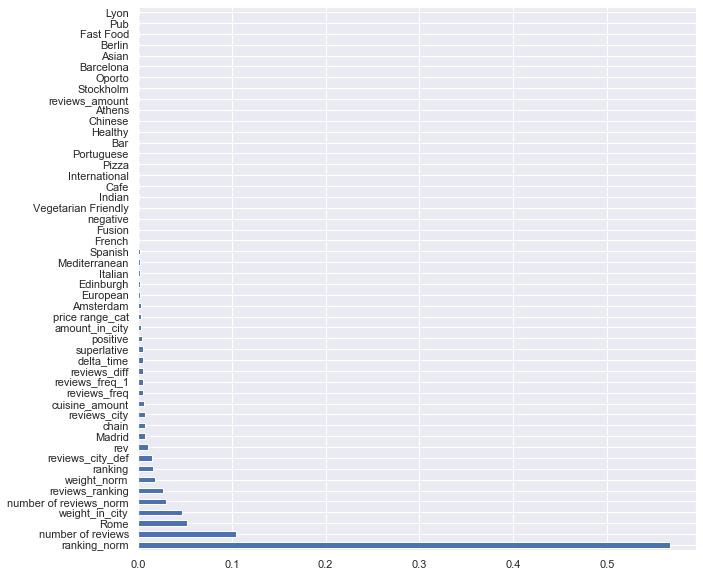

In [721]:
# most important parameters for the Model
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')

In [722]:
feat_importances = feat_importances.sort_values(ascending=False)
feat_importances

ranking_norm              5.673314e-01
number of reviews         1.040482e-01
Rome                      5.183599e-02
weight_in_city            4.614926e-02
number of reviews_norm    2.904890e-02
reviews_ranking           2.665290e-02
weight_norm               1.748819e-02
ranking                   1.577870e-02
reviews_city_def          1.415574e-02
rev                       1.002821e-02
Madrid                    7.402203e-03
chain                     7.152180e-03
reviews_city              6.794142e-03
cuisine_amount            6.067287e-03
reviews_freq              5.296145e-03
reviews_freq_1            5.250251e-03
reviews_diff              5.088150e-03
delta_time                4.911380e-03
superlative               4.861190e-03
positive                  3.557477e-03
amount_in_city            3.168596e-03
price range_cat           2.467424e-03
Amsterdam                 2.374870e-03
European                  1.956071e-03
Edinburgh                 1.623280e-03
Italian                  

Now we can compare the correlation coeffitients (ser_corr) with the resuls of model.feature_importances_:

In [723]:
feat_imp = feat_importances.reset_index().reset_index()
feat_imp.columns = ['place_feat_imp','parameter', 'importancy']
feat_imp

,place_feat_imp,parameter,importancy
0,0,ranking_norm,5.673314e-01
1,1,number of reviews,1.040482e-01
2,2,Rome,5.183599e-02
3,3,weight_in_city,4.614926e-02
4,4,number of reviews_norm,2.904890e-02
5,5,reviews_ranking,2.665290e-02
6,6,weight_norm,1.748819e-02
7,7,ranking,1.577870e-02
8,8,reviews_city_def,1.415574e-02
9,9,rev,1.002821e-02


In [724]:
df_corr_imp = ser_corr[1:].reset_index().reset_index()
df_corr_imp.columns = ['correlation_place','parameter', 'correlation']
df_corr_imp['feat_importances_place'] = 0
df_corr_imp['feat_importances_place'] = df_corr_imp.apply(lambda x: feat_imp['place_feat_imp'][feat_imp['parameter']==x['parameter']].sum(), axis=1)
df_corr_imp[['parameter', 'feat_importances_place', 'correlation_place']]

,parameter,feat_importances_place,correlation_place
0,ranking_norm,0,0
1,ranking,7,1
2,chain,11,2
3,superlative,18,3
4,negative,30,4
5,Vegetarian Friendly,31,5
6,Vegan Options,53,6
7,cuisine_amount,13,7
8,Gluten Free Options,62,8
9,weight_norm,6,9


We see, that the importancy of parameters for the Rating given from "feature_importances_"-attribute does not match the correlation matrix.   

Let's check, if the reduce of parameter can improve the quality of prediction.   
At first we give the 50 most impotant parameter for the prediction of the rating(according the feat_importances).

In [725]:
list_col = feat_importances.sort_values(ascending=False)[:50].index

In [726]:
col = ['rating', 'sample']
for i in range(len(list_col)):
    col.append(list_col[i])
df_preproc_1 = df_preproc[col]
df_preproc_1

,rating,sample,ranking_norm,number of reviews,Rome,weight_in_city,number of reviews_norm,reviews_ranking,weight_norm,ranking,reviews_city_def,rev,Madrid,chain,reviews_city,cuisine_amount,reviews_freq,reviews_freq_1,reviews_diff,delta_time,superlative,positive,amount_in_city,price range_cat,Amsterdam,European,Edinburgh,Italian,Mediterranean,Spanish,French,Fusion,negative,Vegetarian Friendly,Indian,Cafe,International,Pizza,Portuguese,Bar,Healthy,Chinese,Athens,reviews_amount,Stockholm,Oporto,Barcelona,Asian,Berlin,Fast Food,Pub,Lyon
0,0.0,0,0.926840,4.0,0,0.471187,0.000394,1.884749,0.000017,12963.0,0.000006,0.000000,0,16,681118.0,2,0.000000e+00,0.000000,0.0,0,0,0,6108,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,0,0.089710,97.0,0,4.481132,0.064560,434.669811,0.034351,106.0,0.003284,8.962264,0,10,29539.0,5,3.299381e+04,0.381443,3200400.0,37,1,1,475,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
2,0.0,0,0.458357,28.0,0,0.919753,0.005913,25.753086,0.000669,810.0,0.000163,1.839506,0,15,172124.0,1,6.788571e+04,0.785714,1900800.0,22,0,0,745,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
3,0.0,0,0.101441,202.0,0,4.309766,0.020810,870.572798,0.000538,1669.0,0.000216,8.619533,0,9,934195.0,5,5.988119e+03,0.069307,1209600.0,14,0,1,7193,2,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
4,0.0,0,0.038375,162.0,0,10.270270,0.062476,1663.783784,0.077970,37.0,0.009684,20.540541,0,14,16729.0,6,8.000000e+03,0.092593,1296000.0,15,1,1,380,2,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,4.5,1,0.079535,79.0,0,5.388000,0.012266,425.652000,0.001841,500.0,0.000183,10.776000,0,15,431481.0,4,3.718481e+04,0.430380,2937600.0,34,2,0,2694,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
49996,3.5,1,0.453265,542.0,0,0.963255,0.070988,522.084214,0.000259,6341.0,0.000796,1.926510,0,3,681118.0,5,1.434686e+03,0.016605,777600.0,9,0,1,6108,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0
49997,4.5,1,0.670321,4.0,0,0.625303,0.002055,2.501211,0.000200,1652.0,0.000056,1.250605,0,11,71669.0,2,6.754410e+07,781.750000,270176400.0,3127,0,1,1033,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0
49998,4.0,1,0.297260,70.0,0,1.443058,0.029299,101.014041,0.001096,641.0,0.001256,2.886115,0,9,55732.0,5,2.838857e+04,0.328571,1987200.0,23,0,0,925,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0


In [727]:
# extract the test part
train_data_1 = df_preproc_1.query('sample == 1').drop(['sample'], axis=1)
test_data_1 = df_preproc_1.query('sample == 0').drop(['sample'], axis=1)

y_1 = train_data_1.rating.values            # our target
X_1 = train_data_1.drop(['rating'], axis=1)

In [728]:
# Using the function "train_test_split" for splitting the train set for validation
# 20% for validation (test_size value)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=RANDOM_SEED)

In [729]:
# check
test_data_1.shape, train_data_1.shape, X_1.shape, X_train_1.shape, X_test_1.shape

((10000, 51), (40000, 51), (40000, 50), (32000, 50), (8000, 50))

In [730]:
# Model learning on the train set
model.fit(X_train_1, y_train_1)

# Using the model for prediction the rating for the test set.
# Use a variable "y_pred" to save the prediction
y_pred_1 = model.predict(X_test_1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [731]:
# compearing the prediction (y_pred) with real values (y_test), 
# calculation Mean Absolute Error (MAE) 
print('MAE:', metrics.mean_absolute_error(y_test_1, y_pred_1))

MAE: 0.202233125


We see, the MAE become worse.  
Now I want to check what happens if we use 50 parameters with the highest *correlation* with rating.

In [732]:
list_col = df_corr_imp.loc[:49]['parameter']
col = ['rating', 'sample']
for i in range(len(list_col)):
    col.append(list_col[i])
df_preproc_2 = df_preproc[col]
df_preproc_2

,rating,sample,ranking_norm,ranking,chain,superlative,negative,Vegetarian Friendly,Vegan Options,cuisine_amount,Gluten Free Options,weight_norm,Madrid,Rome,delta_time,reviews_diff,Wine Bar,amount_in_city,Milan,Healthy,weight_in_city,Chinese,rev,Mediterranean,Berlin,Delicatessen,Athens,Greek,reviews_ranking,Fusion,Street Food,Contemporary,Amsterdam,Pizza,reviews_city,reviews_city_def,Oporto,number of reviews_norm,Polish,Scottish,price range_cat,Paris,number of reviews,International,American,Stockholm,Cafe,Spanish,Krakow,London,Portuguese,Italian
0,0.0,0,0.926840,12963.0,16,0,0,0,0,2,0,0.000017,0,0,0,0.0,0,6108,0,0,0.471187,0,0.000000,0,0,0,0,0,1.884749,0,0,0,0,0,681118.0,0.000006,0,0.000394,0,0,1,1,4.0,0,0,0,0,0,0,0,0,0
1,0.0,0,0.089710,106.0,10,1,0,1,1,5,1,0.034351,0,0,37,3200400.0,0,475,0,0,4.481132,0,8.962264,0,0,0,0,0,434.669811,0,0,0,0,0,29539.0,0.003284,0,0.064560,0,0,1,0,97.0,0,0,0,0,0,0,0,0,0
2,0.0,0,0.458357,810.0,15,0,0,1,0,1,0,0.000669,0,0,22,1900800.0,0,745,0,0,0.919753,0,1.839506,0,0,0,0,0,25.753086,0,0,0,0,0,172124.0,0.000163,0,0.005913,0,0,1,0,28.0,0,0,0,0,0,0,0,0,0
3,0.0,0,0.101441,1669.0,9,0,0,1,0,5,1,0.000538,0,0,14,1209600.0,0,7193,0,0,4.309766,0,8.619533,1,0,0,0,0,870.572798,0,0,0,0,0,934195.0,0.000216,0,0.020810,0,0,2,0,202.0,0,0,0,0,0,0,1,0,1
4,0.0,0,0.038375,37.0,14,1,0,1,0,6,1,0.077970,0,0,15,1296000.0,0,380,0,0,10.270270,0,20.540541,1,0,0,0,0,1663.783784,0,0,0,0,0,16729.0,0.009684,0,0.062476,0,0,2,0,162.0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,4.5,1,0.079535,500.0,15,2,0,1,1,4,1,0.001841,0,0,34,2937600.0,0,2694,1,0,5.388000,0,10.776000,0,0,0,0,0,425.652000,0,0,0,0,0,431481.0,0.000183,0,0.012266,0,0,1,0,79.0,0,0,0,0,0,0,0,0,1
49996,3.5,1,0.453265,6341.0,3,0,0,1,0,5,0,0.000259,0,0,9,777600.0,0,6108,0,0,0.963255,0,1.926510,0,0,0,0,0,522.084214,0,0,0,0,0,681118.0,0.000796,0,0.070988,0,0,1,1,542.0,0,1,0,0,0,0,0,0,0
49997,4.5,1,0.670321,1652.0,11,0,0,0,0,2,0,0.000200,0,0,3127,270176400.0,0,1033,0,0,0.625303,0,1.250605,0,0,0,0,0,2.501211,0,0,0,0,0,71669.0,0.000056,0,0.002055,0,0,1,0,4.0,0,0,1,0,0,0,0,0,0
49998,4.0,1,0.297260,641.0,9,0,0,1,0,5,0,0.001096,0,0,23,1987200.0,0,925,0,0,1.443058,0,2.886115,0,0,0,0,0,101.014041,0,0,0,0,0,55732.0,0.001256,0,0.029299,1,0,1,0,70.0,0,0,0,0,0,0,0,0,0


In [733]:
# extract the test part
train_data_2 = df_preproc_2.query('sample == 1').drop(['sample'], axis=1)
test_data_2 = df_preproc_2.query('sample == 0').drop(['sample'], axis=1)

y_2 = train_data_2.rating.values            # our target
X_2 = train_data_2.drop(['rating'], axis=1)

In [734]:
# Using the function "train_test_split" for splitting the train set for validation
# 20% for validation (test_size value)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=RANDOM_SEED)

In [735]:
# check
test_data_2.shape, train_data_2.shape, X_2.shape, X_train_2.shape, X_test_2.shape

((10000, 51), (40000, 51), (40000, 50), (32000, 50), (8000, 50))

In [736]:
# Model learning on the train set
model.fit(X_train_2, y_train_2)

# Using the model for prediction the rating for the test set.
# Use a variable "y_pred" to save the prediction
y_pred_2 = model.predict(X_test_2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [737]:
# compearing the prediction (y_pred) with real values (y_test), 
# calculation Mean Absolute Error (MAE) 
print('MAE:', metrics.mean_absolute_error(y_test_2, y_pred_2))

MAE: 0.20160375


We see, a reducing the number of parameters does not help to improve a MAE . So we will not reduce the amount of parameter for submission to the Kaggle-competition.   

# Submission


In [738]:
test_data.sample(10)

,ranking,number of reviews,rating,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,chain,amount_in_city,cuisine_amount,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,Belgian,Brazilian,Brew Pub,British,Burmese,Cafe,Cambodian,Canadian,Caribbean,Caucasian,Central American,Central Asian,Central European,Chilean,Chinese,Colombian,Contemporary,Croatian,Cuban,Czech,Danish,Delicatessen,Diner,Dutch,Eastern European,Ecuadorean,Egyptian,Ethiopian,European,Fast Food,Filipino,French,Fujian,Fusion,Gastropub,Georgian,German,Gluten Free Options,Greek,Grill,Halal,Hawaiian,Healthy,Hungarian,Indian,Indonesian,International,Irish,Israeli,Italian,Jamaican,Japanese,Korean,Kosher,Latin,Latvian,Lebanese,Malaysian,Mediterranean,Mexican,Middle Eastern,Minority Chinese,Mongolian,Moroccan,Native American,Nepali,New Zealand,Norwegian,Pakistani,Persian,Peruvian,Pizza,Polish,Polynesian,Portuguese,Pub,Romanian,Russian,Salvadoran,Scandinavian,Scottish,Seafood,Singaporean,Slovenian,Soups,South American,Southwestern,Spanish,Sri Lankan,Steakhouse,Street Food,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,price range_cat,reviews_amount,reviews_diff,reviews_freq,reviews_freq_1,delta_time,positive,superlative,negative,weight_in_city,rev,reviews_city,reviews_city_def,reviews_ranking,ranking_norm,number of reviews_norm,weight_norm
1399,1994.0,289.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,7,2589,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,2,9331200.0,3.228789e+04,0.373702,108,0,1,0,1.298395,2.596790,728311.0,0.000397,375.236209,0.335127,0.032265,0.000333
3354,1187.0,25.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2705,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.000000e+00,0.000000,0,1,1,0,2.278854,2.278854,156183.0,0.000160,56.971356,0.186028,0.009335,0.001371
6707,5290.0,26.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7193,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8989200.0,3.457385e+05,4.000000,104,0,1,0,1.359735,2.719471,934195.0,0.000028,35.353119,0.321657,0.002588,0.000128
2228,3926.0,141.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6,6108,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,4320000.0,3.063830e+04,0.354610,50,0,1,1,1.555782,3.111564,681118.0,0.000207,219.365257,0.280555,0.018370,0.000550
612,1191.0,6.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,836,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,17629200.0,2.938200e+06,34.000000,204,1,2,0,0.701931,1.403862,122844.0,0.000049,4.211587,0.606851,0.001433,0.001320
9431,

In [739]:
test_data = test_data.drop(['rating'], axis=1)

In [740]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [742]:
# Model learning on the train set
model.fit(X_train, y_train)

# Using the model for prediction the rating for the test set.
# Use a variable "y_pred" to save the prediction
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [743]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [744]:
predict_submission

array([3.16 , 4.215, 4.43 , ..., 3.035, 4.48 , 4.25 ])

In [745]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.160
1,id_1,4.215
2,id_2,4.430
3,id_3,4.300
4,id_4,4.455
5,id_5,4.505
6,id_6,1.665
7,id_7,3.665
8,id_8,4.275
9,id_9,4.675
